In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import h5py
import numpy as np
import random
from imutils import paths
from google.colab.patches import cv2_imshow  # Import for displaying images in Colab

# Define paths
input_folder = "/content/drive/MyDrive/Images/"  # Folder containing original images
output_folder = "/content/drive/MyDrive/ROTATE2__IMAGE"  # Folder to save rotated images
hdf5_path = "/content/drive/MyDrive/output/dataset.h5"  # Output HDF5 file

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Define possible rotation angles
angles = [0, 90, 180, 270]

# Initialize lists to store image data and labels
image_data = []
labels = []

# Get image paths
imagePaths = list(paths.list_images(input_folder))

print("[INFO] Creating dataset with one random rotation per image...")

# Counter for tracking progress
processed_count = 0

for imagePath in imagePaths:
    # Read the image
    image = cv2.imread(imagePath)
    if image is None:
        continue

    # Resize image to a fixed size (224x224)
    image = cv2.resize(image, (224, 224))

    # Select one random rotation angle for this image
    angle = random.choice(angles)

    # Rotate the image
    if angle == 0:
        rotated = image.copy()  # No rotation, use original image
    else:
        rotated = cv2.rotate(image, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])

    # Save rotated image to disk
    filename = f"rotated_{angle}_{os.path.basename(imagePath)}"
    save_path = os.path.join(output_folder, filename)
    cv2.imwrite(save_path, rotated)

    # Convert image to NumPy array and normalize
    rotated = rotated.astype("float32") / 255.0

    # Append image and label to lists
    image_data.append(rotated)
    labels.append(angle)

    # Increment counter
    processed_count += 1

    # Print progress every 500 images
    if processed_count % 500 == 0:
        print(f"[INFO] Processed {processed_count} images so far...")

# Convert lists to NumPy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Save data to HDF5 file
print("[INFO] Saving dataset to HDF5 file...")
with h5py.File(hdf5_path, "w") as db:
    db.create_dataset("images", data=image_data)
    db.create_dataset("labels", data=labels)

print(f"[INFO] Dataset saved as {hdf5_path} with {len(labels)} images.")
print("[INFO] Dataset successfully created with one random rotation per image!")


[INFO] Creating dataset with one random rotation per image...
[INFO] Processed 500 images so far...
[INFO] Processed 1000 images so far...
[INFO] Processed 1500 images so far...
[INFO] Processed 2000 images so far...
[INFO] Processed 2500 images so far...
[INFO] Processed 3000 images so far...
[INFO] Processed 3500 images so far...
[INFO] Processed 4000 images so far...
[INFO] Processed 4500 images so far...
[INFO] Processed 5000 images so far...
[INFO] Processed 5500 images so far...
[INFO] Processed 6000 images so far...
[INFO] Processed 6500 images so far...
[INFO] Processed 7000 images so far...
[INFO] Processed 7500 images so far...
[INFO] Processed 8000 images so far...
[INFO] Processed 8500 images so far...
[INFO] Processed 9000 images so far...
[INFO] Processed 9500 images so far...
[INFO] Processed 10000 images so far...
[INFO] Processed 10500 images so far...
[INFO] Processed 11000 images so far...
[INFO] Processed 11500 images so far...
[INFO] Processed 12000 images so far..

Keys in the file: ['images', 'labels']
Image shape: (15754, 224, 224, 3)
Label shape: (15754,)


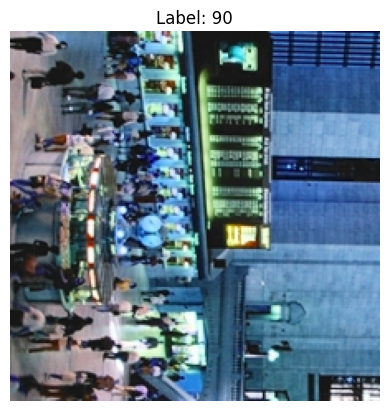

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Define file path
file_path = "/content/drive/MyDrive/output/dataset.h5"

# Open the HDF5 file and load data
with h5py.File(file_path, "r") as hdf:
    print("Keys in the file:", list(hdf.keys()))  # Check available datasets

    # Load images and labels (update keys if different)
    images = np.array(hdf["images"])
    labels = np.array(hdf["labels"])

# Print dataset shapes
print("Image shape:", images.shape)
print("Label shape:", labels.shape)

# Visualize an image
plt.imshow(images[0], cmap="gray")  # Change cmap if needed
plt.title(f"Label: {labels[0]}")
plt.axis("off")
plt.show()


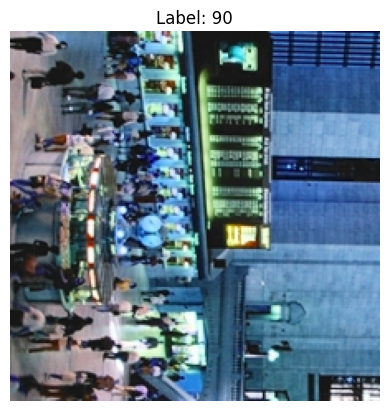

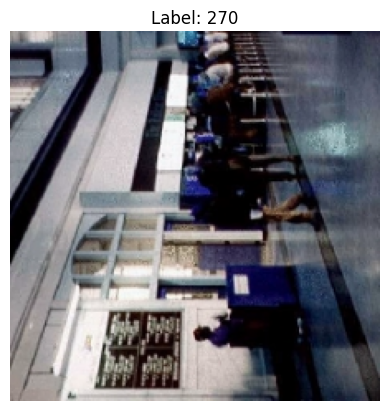

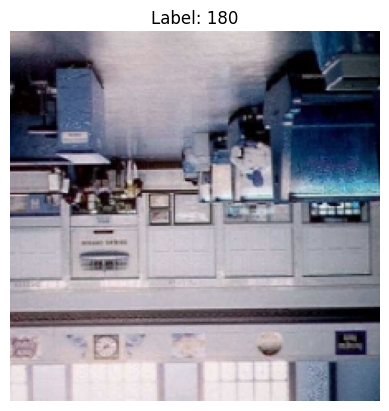

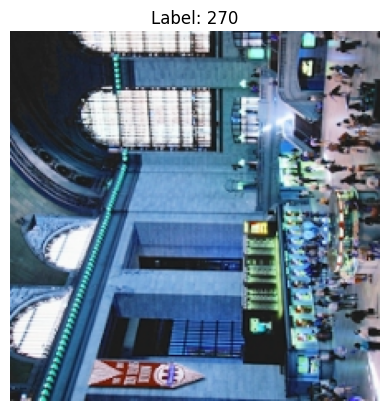

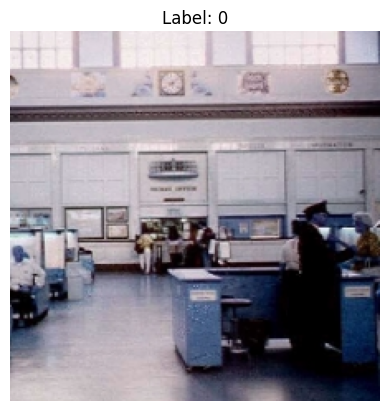

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Define file path
file_path = "/content/drive/MyDrive/output/dataset.h5"

# Open the HDF5 file and load data
with h5py.File(file_path, "r") as hdf:
    images = np.array(hdf["images"])
    labels = np.array(hdf["labels"])

# Display 5 images
for i in range(5):
    plt.figure()  # Create a new figure for each image
    plt.imshow(images[i], cmap="gray")  # Display the image
    plt.title(f"Label: {labels[i]}")  # Set the title with the label
    plt.axis("off")  # Hide axes
    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
with tf.device('/GPU:0'):  # Make sure GPU is used
    vgg = VGG16(weights="imagenet", include_top=False)


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow CPU/GPU log messages


In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Suppress TensorFlow CPU/GPU log messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define paths
hdf5_path = "/content/drive/MyDrive/output/dataset.h5"  # Path to dataset
features_path_hdf5 = "/content/drive/MyDrive/output/features_label.h5"  # Path to save extracted features

# ✅ Load dataset
print("[INFO] Loading dataset...")
with h5py.File(hdf5_path, "r") as db:
    images = np.array(db["images"])  # (N, 224, 224, 3)
    labels = np.array(db["labels"])  # (N,)

# Normalize images
images = images.astype("float32") / 255.0

# Convert labels to categories (0,1,2,3 for 0°, 90°, 180°, 270°)
labels = labels / 90  # Convert angles (0,90,180,270) to (0,1,2,3)

# ✅ Load pre-trained VGG16 (without fully connected layers)
print("[INFO] Extracting features using VGG16...")
with tf.device('/GPU:0'):  # Ensure GPU is used for feature extraction
    vgg = VGG16(weights="imagenet", include_top=False)

    # Load or create HDF5 file for storing features and labels
    if os.path.exists(features_path_hdf5):
        print("[INFO] HDF5 file exists. Loading existing data...")
        with h5py.File(features_path_hdf5, "r") as db:
            existing_features = np.array(db["features"])
            existing_labels = np.array(db["labels"])
            start_index = len(existing_labels)  # Resume from the last processed image
            print(f"[INFO] Resuming from image {start_index + 1}")
    else:
        existing_features = []
        existing_labels = []
        start_index = 0
        print("[INFO] Starting fresh extraction...")

    # Extract features
    for i in range(start_index, len(images)):
        img = np.expand_dims(images[i], axis=0)
        img = preprocess_input(img)  # Preprocessing for VGG16
        feature = vgg.predict(img)
        feature = feature.flatten()  # Convert to 1D vector

        # Append the feature and label to the existing arrays
        existing_features.append(feature)
        existing_labels.append(labels[i])

        # Save progress periodically (every 500 images)
        if (i + 1) % 500 == 0 or i == len(images) - 1:
            print(f"[INFO] Extracted features for {i + 1} images...")
            with h5py.File(features_path_hdf5, "w") as db:
                db.create_dataset("features", data=np.array(existing_features))
                db.create_dataset("labels", data=np.array(existing_labels))
            print(f"[INFO] Saved progress at image {i + 1}")

    print("[INFO] Feature extraction complete.")


Num GPUs Available:  1
[INFO] Loading dataset...
[INFO] Extracting features using VGG16...
[INFO] HDF5 file exists. Loading existing data...
[INFO] Resuming from image 15755
[INFO] Feature extraction complete.


In [ ]:
import h5py
import numpy as np

# Path to the HDF5 file where features and labels are stored
features_path_hdf5 = "/content/drive/MyDrive/output/features_label.h5"

# Load the HDF5 file
with h5py.File(features_path_hdf5, "r") as db:
    # Load features dataset
    features = np.array(db["features"])

# Print the first 10 features
print("[INFO] First 10 features:")
print(features[:10],labels[:10])  # Display the first 10 features


[INFO] First 10 features:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [1. 3. 2. 3. 0. 2. 1. 3. 2. 3.]


In [ ]:
import h5py

# Path to the HDF5 file where features and labels are stored
features_path_hdf5 = "/content/drive/MyDrive/output/features_label.h5"

# Load the HDF5 file
with h5py.File(features_path_hdf5, "r") as db:
    # Print the names of all arrays (datasets) in the file
    print("[INFO] Dataset names in the HDF5 file:")
    print(list(db.keys()))  # List of dataset names in the file


[INFO] Dataset names in the HDF5 file:
['features', 'labels']


In [ ]:
import os
import h5py
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Suppress TensorFlow CPU/GPU log messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define paths
hdf5_path = "/content/drive/MyDrive/output/dataset.h5"  # Path to dataset
features_path = "/content/drive/MyDrive/output/features.npy"  # Path to save extracted features

# ✅ Load dataset
print("[INFO] Loading dataset...")
with h5py.File(hdf5_path, "r") as db:
    images = np.array(db["images"])  # (N, 224, 224, 3)
    labels = np.array(db["labels"])  # (N,)

# Normalize images
images = images.astype("float32") / 255.0

# Convert labels to categories (0,1,2,3 for 0°, 90°, 180°, 270°)
labels = labels / 90  # Convert angles (0,90,180,270) to (0,1,2,3)

# ✅ Load pre-trained VGG16 (without fully connected layers)
print("[INFO] Initializing VGG16 for feature extraction...")
with tf.device('/GPU:0'):  # Ensure GPU is used for feature extraction
    vgg = VGG16(weights="imagenet", include_top=False)

# ✅ Check if a saved feature file exists to resume progress
if os.path.exists(features_path):
    print("[INFO] Found saved feature file. Loading progress...")
    features = np.load(features_path).tolist()  # Convert back to a list for appending
    start_index = len(features)  # Resume from this index
else:
    print("[INFO] No saved feature file found. Starting from scratch...")
    features = []
    start_index = 0

# ✅ Resume feature extraction
print(f"[INFO] Resuming from image {start_index}/{len(images)}...")
with tf.device('/GPU:0'):
    for i in range(start_index, len(images)):
        img = np.expand_dims(images[i], axis=0)
        img = preprocess_input(img)  # Preprocessing for VGG16
        feature = vgg.predict(img)
        feature = feature.flatten()  # Convert to 1D vector
        features.append(feature)

        # Save progress every 500 images
        if (i + 1) % 500 == 0 or (i + 1) == len(images):
            np.save(features_path, np.array(features))  # Save progress
            print(f"[INFO] Saved progress at image {i + 1}/{len(images)}.")

print("[INFO] Feature extraction complete and saved successfully.")


Num GPUs Available:  1
[INFO] Loading dataset...
[INFO] Initializing VGG16 for feature extraction...
[INFO] Found saved feature file. Loading progress...
[INFO] Resuming from image 15754/15754...
[INFO] Feature extraction complete and saved successfully.


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

model_path = "/content/drive/MyDrive/output/logistic_orientation_tuned.pkl"  # Path to save trained model

# ✅ Split dataset
(trainX, testX, trainY, testY) = train_test_split(features, labels, test_size=0.25, random_state=42)

# ✅ Hyperparameter tuning using GridSearchCV
print("[INFO] Tuning hyperparameters for Logistic Regression...")
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
}

# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Use GridSearchCV to search over hyperparameters
grid_search = GridSearchCV(logreg, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(trainX, trainY)

# Get the best hyperparameters
print("[INFO] Best hyperparameters found: ", grid_search.best_params_)

# ✅ Evaluate the tuned model
print("[INFO] Evaluating the model...")
best_model = grid_search.best_estimator_
preds = best_model.predict(testX)
print(classification_report(testY, preds))

# ✅ Save the trained and tuned model
print("[INFO] Saving the tuned model...")
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Tuned model saved as {model_path}")

[INFO] Loading extracted features and labels from Drive...
[INFO] Tuning hyperparameters for Logistic Regression...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] Best hyperparameters found:  {'C': 100.0}
[INFO] Evaluating the model...
              precision    recall  f1-score   support

         0.0       0.34      0.34      0.34       991
         1.0       0.34      0.30      0.32       982
         2.0       0.35      0.30      0.32       998
         3.0       0.31      0.38      0.34       968

    accuracy                           0.33      3939
   macro avg       0.33      0.33      0.33      3939
weighted avg       0.33      0.33      0.33      3939

[INFO] Saving the tuned model...
✅ Tuned model saved as /content/drive/MyDrive/output/logistic_orientation_tuned.pkl


In [ ]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pickle

model_path = "/content/drive/MyDrive/output/logistic_orientation_tuned.pkl"  # Path to save trained model
features_path_hdf5 = "/content/drive/MyDrive/output/features_label.h5"  # Path to the HDF5 file with features and labels

# ✅ Load features and labels from HDF5 file
print("[INFO] Loading features and labels from HDF5 file...")
with h5py.File(features_path_hdf5, "r") as db:
    features = np.array(db["features"])  # Load features dataset
    r = np.array(db["labels"])  # Load labels dataset

# ✅ Split dataset
(trainX, testX, trainY, testY) = train_test_split(features, r, test_size=0.25, random_state=42)

# ✅ Hyperparameter tuning using GridSearchCV
print("[INFO] Tuning hyperparameters for Logistic Regression...")
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
}

# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Use GridSearchCV to search over hyperparameters
grid_search = GridSearchCV(logreg, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(trainX, trainY)

# Get the best hyperparameters
print("[INFO] Best hyperparameters found: ", grid_search.best_params_)

# ✅ Evaluate the tuned model
print("[INFO] Evaluating the model...")
best_model = grid_search.best_estimator_
preds = best_model.predict(testX)
print(classification_report(testY, preds))

# ✅ Save the trained and tuned model
print("[INFO] Saving the tuned model...")
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Tuned model saved as {model_path}")


[INFO] Loading features and labels from HDF5 file...
[INFO] Tuning hyperparameters for Logistic Regression...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] Best hyperparameters found:  {'C': 100.0}
[INFO] Evaluating the model...
              precision    recall  f1-score   support

         0.0       0.34      0.34      0.34       991
         1.0       0.34      0.30      0.32       982
         2.0       0.35      0.30      0.32       998
         3.0       0.31      0.38      0.34       968

    accuracy                           0.33      3939
   macro avg       0.33      0.33      0.33      3939
weighted avg       0.33      0.33      0.33      3939

[INFO] Saving the tuned model...
✅ Tuned model saved as /content/drive/MyDrive/output/logistic_orientation_tuned.pkl


In [ ]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import pickle

# Define paths
model_path = "/content/drive/MyDrive/output/logistic_orientation_tuned.pkl"  # Path to save trained model
features_path_hdf5 = "/content/drive/MyDrive/output/features_label.h5"  # Path to the HDF5 file with features and labels

# ✅ Load features and labels from HDF5 file
print("[INFO] Loading features and labels from HDF5 file...")
with h5py.File(features_path_hdf5, "r") as db:
    features = np.array(db["features"])  # Load features dataset
    labels = np.array(db["labels"])  # Load labels dataset

# ✅ Feature Scaling (important for Logistic Regression and SVM)
print("[INFO] Scaling features...")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)  # Scale the features

# ✅ Split dataset
(trainX, testX, trainY, testY) = train_test_split(features_scaled, labels, test_size=0.25, random_state=42)

# ✅ Hyperparameter tuning using GridSearchCV with Logistic Regression and Random Forest
print("[INFO] Tuning hyperparameters for Logistic Regression and Random Forest...")
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Logistic Regression regularization strength
}

# Initialize models
logreg = LogisticRegression(class_weight='balanced')  # Adding class_weight to handle imbalance
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Create a list of models for tuning
models = [logreg, rf]

# Loop through each model for hyperparameter tuning
best_model = None
best_score = 0
for model in models:
    print(f"[INFO] Tuning {model.__class__.__name__}...")

    if isinstance(model, LogisticRegression):
        grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1)
    else:
        # You can create a more elaborate grid for Random Forest or other models
        param_grid_rf = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
        }
        grid_search = GridSearchCV(model, param_grid_rf, cv=3, n_jobs=-1, verbose=1)

    grid_search.fit(trainX, trainY)

    # Get the best model
    print(f"[INFO] Best hyperparameters found for {model.__class__.__name__}: ", grid_search.best_params_)

    # Evaluate performance
    score = grid_search.best_score_
    if score > best_score:
        best_score = score
        best_model = grid_search.best_estimator_

# ✅ Evaluate the tuned model on test set
print("[INFO] Evaluating the best model on test set...")
preds = best_model.predict(testX)
print(classification_report(testY, preds))

# ✅ Save the best tuned model
print("[INFO] Saving the tuned model...")
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Tuned model saved as {model_path}")


[INFO] Loading features and labels from HDF5 file...
[INFO] Scaling features...
[INFO] Tuning hyperparameters for Logistic Regression and Random Forest...
[INFO] Tuning LogisticRegression...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[INFO] Best hyperparameters found for LogisticRegression:  {'C': 0.01}
[INFO] Tuning RandomForestClassifier...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[INFO] Best hyperparameters found for RandomForestClassifier:  {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
[INFO] Evaluating the best model on test set...
              precision    recall  f1-score   support

         0.0       0.36      0.37      0.36       991
         1.0       0.37      0.37      0.37       982
         2.0       0.38      0.36      0.37       998
         3.0       0.36      0.35      0.36       968

    accuracy                           0.36      3939
   macro avg       0.36      0.36      0.36      3939
weighted avg       0

In [ ]:
import pickle
import numpy as np
import cv2
import imutils
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# ✅ Define paths
model_path = "/content/drive/MyDrive/output/logistic_orientation_tuned.pkl"  # Path to save trained model
image_path = "/content/drive/MyDrive/ROTATE2__IMAGE/rotated_0_bakery_02_14_yahoo.jpg"  # Path to the image to correct

# ✅ Load trained Logistic Regression model
print("[INFO] Loading trained model...")
with open(model_path, "rb") as f:
    model = pickle.load(f)

# ✅ Load VGG16 for feature extraction
print("[INFO] Loading VGG16 model...")
vgg = VGG16(weights="imagenet", include_top=False)


[INFO] Loading trained model...
[INFO] Loading VGG16 model...


In [ ]:
# ✅ Load and preprocess the image
print("[INFO] Processing image...")
orig = cv2.imread(image_path)  # Load using OpenCV

image = load_img(image_path, target_size=(224, 224))  # Resize
image = img_to_array(image)  # Convert to array
image = np.expand_dims(image, axis=0)  # Expand dimensions
image = preprocess_input(image)  # Preprocessing for VGG16

# ✅ Extract features using VGG16
print("[INFO] Extracting features...")
features = vgg.predict(image)
features = features.flatten().reshape(1, -1)  # Flatten & reshape


[INFO] Processing image...
[INFO] Extracting features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


[INFO] Predicted rotation angle: 180°


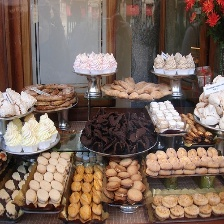

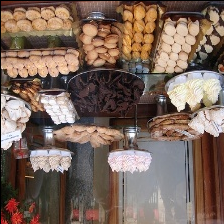

In [ ]:
from google.colab.patches import cv2_imshow

# ✅ Predict the image orientation
pred_angle_index = model.predict(features)[0]  # Get predicted class (0,1,2,3)
angle = int(pred_angle_index) * 90  # Convert index to actual angle

print(f"[INFO] Predicted rotation angle: {angle}°")

# ✅ Correct the image orientation
corrected = imutils.rotate_bound(orig, 360 - angle)  # Rotate to correct

# ✅ Display images correctly in Colab
cv2_imshow(orig)  # Show original image
cv2_imshow(corrected)  # Show corrected image
